# Домашнее задание 3. Pandas (HW)

## Описание задачи
В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.

## Цель

Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

- Проанализированы все возможные признаки
- Код хорошо читается и задокументирован, соответствует pep-8
- Код работоспособный

## Описание данных

### train.csv
- row_id: (int64) Идентификатор строки.
- timestamp: (int64) время в миллисекундах между взаимодействием пользователя и первым завершением события от этого пользователя.
- user_id: (int32) Идентификатор польователя.
- content_id: (int16) Идентификатор пользовательского взаимодействия
- content_type_id: (int8) 0, если событием был вопрос, заданный пользователю, 1, если событием был просмотр пользователем лекции.
- task_container_id: (int16) Код идентификатора для пакета вопросов или лекций. Например, пользователь может увидеть три вопроса подряд, прежде чем увидеть объяснения для любого из них. Все эти три вопроса будут иметь общий task_container_id.
- user_answer: (int8) ответ пользователя на вопрос, если таковой имеется. Читать -1 как NULL, для лекций.
- answered_correctly: (int8) если пользователь ответил правильно. Читайте -1 как NULL, для лекций.
- prior_question_elapsed_time: (float32) Среднее время в миллисекундах, которое потребовалось пользователю для ответа на каждый вопрос в предыдущем пакете вопросов, игнорируя любые лекции между ними. Имеет значение null для первого пакета вопросов или лекции пользователя. Обратите внимание, что время — это среднее время, которое потребовалось пользователю для решения каждого вопроса в предыдущем пакете.
- prior_question_had_explanation: (bool) Увидел ли пользователь объяснение и правильный ответ(ы) после ответа на предыдущий пакет вопросов, игнорируя любые лекции между ними. Значение является общим для одного пакета вопросов и равно NULL для первого пакета вопросов или лекции пользователя. Обычно первые несколько вопросов, которые видит пользователь, были частью диагностического теста на вступление, где он не получал никакой обратной связи.


### questions.csv: метаданные вопросов, заданных пользователям.
- question_id: внешний ключ для обучающего/тестового столбца content_id, когда тип контента — вопрос (0).
- bundle_id: код, по которому вопросы подаются вместе.
- correct_answer: ответ на вопрос. Можно сравнить с train user_answer столбцом, чтобы проверить, был ли пользователь прав.
- part: соответствующий раздел теста TOEIC.
- tags: один или несколько подробных кодов тегов для вопроса. Значение тегов не будет предоставлено, но этих кодов достаточно для кластеризации вопросов.


### lectures.csv: метаданные лекций, просмотренных пользователями по мере продвижения своего образования.
- lecture_id: внешний ключ для обучающего/тестового столбца content_id, когда типом контента является лекция (1).
- part: код категории верхнего уровня для лекции.
- tag: один тег коды для лекции. Значение тегов не будет предоставлено, но эти коды достаточны для кластеризации лекций вместе.
- type_of: краткое описание основной цели лекции.

# Setup

## Library import

In [148]:
import warnings 
warnings.filterwarnings('ignore')

from omegaconf import OmegaConf
from collections import Counter

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
from matplotlib.ticker import FuncFormatter
colorMap = sns.light_palette("blue", as_cmap=True)

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameter definition

Здесь приведены все параметры для блокнота

In [2]:
cfg = OmegaConf.create({
    "train_path" : "./data/train.csv", 
    "lectures_path" : "./data/lectures.csv", 
    "questions_path" : "./data/questions.csv", 
})

In [3]:
cfg

{'train_path': './data/train.csv', 'lectures_path': './data/lectures.csv', 'questions_path': './data/questions.csv'}

# Data import

### Загрузка тренировочных данных

Тренировочные данные имеют большой размер. Можно попробывать 2 способа их загрузки

1. Загрузить без параметров

In [4]:
%%time

train_df = pd.read_csv(cfg.train_path)

CPU times: total: 1min 33s
Wall time: 1min 43s


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


2. Загрузка с перечесление типов данных для котлонок

In [4]:
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

In [5]:
%%time

train_df = pd.read_csv(cfg.train_path, dtype=dtypes)

CPU times: total: 3min 9s
Wall time: 4min 9s


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 boolean
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 3.2 GB


Вывод: во втором случае сократилось использование памяти в 2 раза.

In [9]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


In [10]:
train_df.shape

(101230332, 10)

### Загрузка метаданных лекций

In [61]:
lectures_df = pd.read_csv(cfg.lectures_path)

In [62]:
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [63]:
lectures_df.shape

(418, 4)

### Загрузка метаданных вопросов

In [64]:
questions_df = pd.read_csv(cfg.questions_path)

In [65]:
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [66]:
questions_df.shape

(13523, 5)

# Data processing

## EDA Train

In [17]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


In [18]:
train_df.shape

(101230332, 10)

### Поиск дубликатов

In [19]:
len(train_df) - len(train_df.drop_duplicates())

0

Вывод:
- Дубликатов нет

### Анализ пропусков в данных

In [23]:
train_df.count()

row_id                            101230332
timestamp                         101230332
user_id                           101230332
content_id                        101230332
content_type_id                   101230332
task_container_id                 101230332
user_answer                       101230332
answered_correctly                101230332
prior_question_elapsed_time        98878794
prior_question_had_explanation    100837826
dtype: int64

Вывод:
 - NULL содержат только колонки prior_question_elapsed_time и prior_question_had_explanation, как и было написано в их описании
 - prior_question_elapsed_time - Имеет значение null для первого пакета вопросов или лекции пользователя.
 - prior_question_had_explanation - Значение является общим для одного пакета вопросов и равно NULL для первого пакета вопросов или лекции пользователя.

### Анализ целевой переменной

Так как задача заключается в анализе как можно большего количества характеристик, влияющих на успеваемость студентов,
то целевым параметром является answered_correctly - правильность ответа студента на вопрос

In [26]:
train_df["answered_correctly"].value_counts(normalize=True)

answered_correctly
 1    0.644517
 0    0.336131
-1    0.019352
Name: proportion, dtype: float64

Значение -1 не относится к прохождению тестов, его нужно исключить

In [32]:
answered_question_mask = (train_df["answered_correctly"] != -1)

In [33]:
train_df["answered_correctly"].loc[answered_question_mask].value_counts(normalize=True)

answered_correctly
1    0.657236
0    0.342764
Name: proportion, dtype: float64

In [36]:
answered_questions = train_df["answered_correctly"].loc[answered_question_mask].value_counts()
answered_questions

answered_correctly
1    65244627
0    34026673
Name: count, dtype: int64

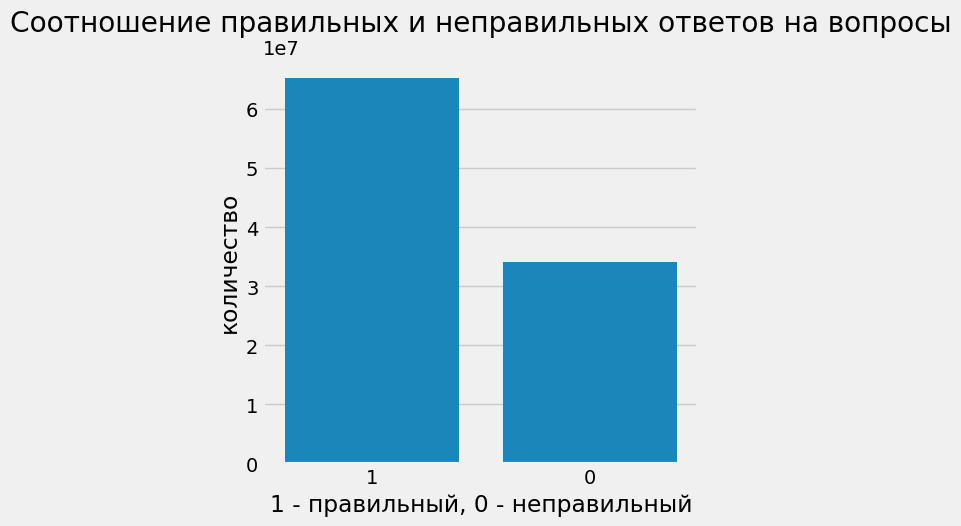

In [44]:
answered_questions = train_df["answered_correctly"].loc[answered_question_mask].value_counts()
# sns.countplot( x='answered_correctly', data=answered_questions)
plt.figure(figsize=(5, 5))
sns.barplot(x=answered_questions.index.astype('int'), y=answered_questions.values, order=answered_questions.index.astype('int'))
plt.title('Соотношение правильных и неправильных ответов на вопросы')
plt.xlabel('1 - правильный, 0 - неправильный')
plt.ylabel('количество');

Выводы:
 - около 33% ответов были даны неправильно

### Анализ переменной user_answer

In [47]:
train_df["user_answer"].value_counts()

user_answer
 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: count, dtype: int64

In [ ]:
Читать -1 как NULL, для лекций.

<Axes: xlabel='user_answer', ylabel='count'>

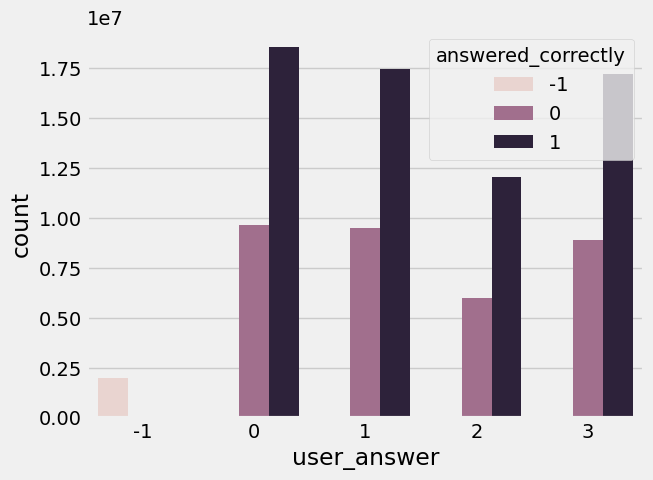

In [48]:
sns.countplot(x='user_answer', hue='answered_correctly',data=train_df)

In [53]:
answered_question_mask = (train_df["answered_correctly"] != -1)
user_answer_mask = (train_df["user_answer"] != -1)
train_df[['user_answer', 'answered_correctly']].loc[answered_question_mask & user_answer_mask].corr()

,user_answer,answered_correctly
user_answer,1.000000,0.004881
answered_correctly,0.004881,1.000000


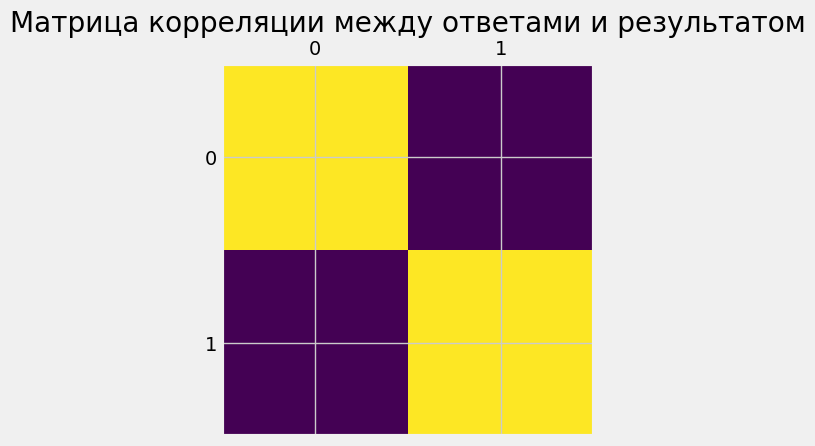

In [54]:
answered_question_mask = (train_df["answered_correctly"] != -1)
user_answer_mask = (train_df["user_answer"] != -1)
plt.matshow(train_df[['user_answer', 'answered_correctly']].loc[answered_question_mask & user_answer_mask].corr())
plt.title('Матрица корреляции между ответами и результатом')
plt.show()

Вывод:
- Колонка user_answer, скорее всего, отвечает на вопрос - какой из представленных вариантов ответов выбрал студет. 
- Похоже, что вопросы имеют множественный выбор - ответы 0-3.
- Значение -1 означает отсутствие ответа при просмотре лекции, должно быть исключено.
- Гораздо больше контента, связанного с вопросами, чем с лекциями

### Анализ переменной content_type_id

Нужно привести тип данных к int

In [7]:
train_df["content_type_id"] = train_df["content_type_id"].astype("int")

<Axes: xlabel='content_type_id', ylabel='count'>

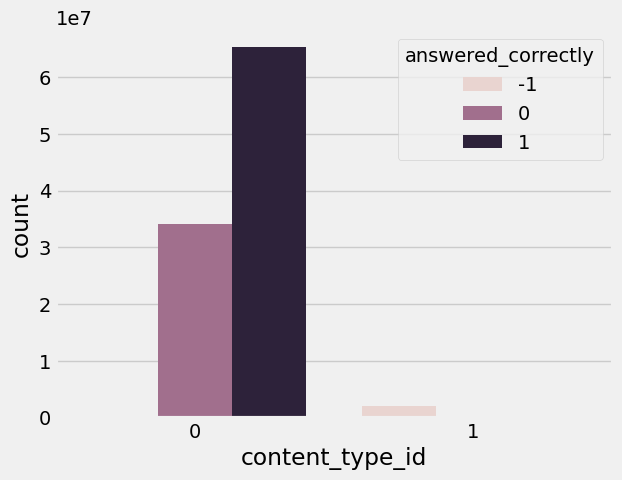

In [8]:
sns.countplot(x='content_type_id', hue='answered_correctly', data=train_df)

Выводы:
- content_type_id = 0, для вопроса, 1 для лекции
- обозначает тип образовательного контента, не влияет на целевую переменную

### Анализ переменной timestamp

In [16]:
ms_per_year = 31_556_952_000
ms_per_month = ms_per_year/12

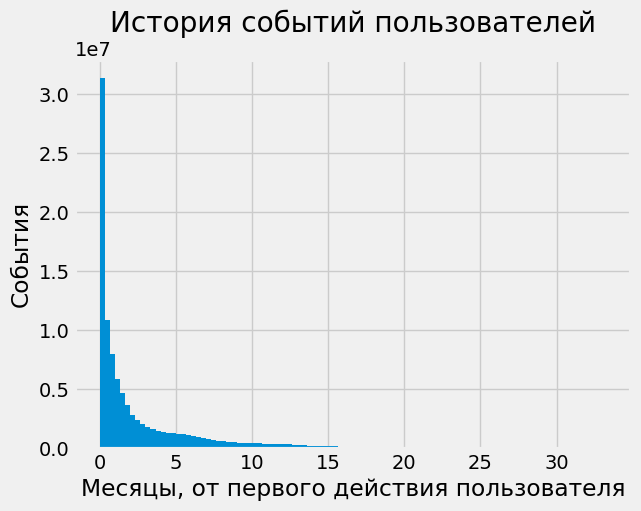

In [18]:
ts = train_df['timestamp']/ms_per_month
ts.plot.hist(bins=100)
plt.title("История событий пользователей")
plt.xticks(rotation=0)
plt.xlabel("Месяцы, от первого действия пользователя")
plt.ylabel("События")
plt.show()

Проверка связи между 'timestamp' и успеваимостью 'answered_correctly',

In [38]:
%%time

bin_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
train_df['ts_bin'] = pd.qcut(train_df['timestamp'], q=10, labels=bin_labels)
answered_question_mask = (train_df["answered_correctly"] != -1)
answered_question_ts_df = (
    train_df.loc[answered_question_mask]
    .groupby(["ts_bin", 'answered_correctly'], as_index=False)
    .size()
)
answered_question_ts_df = answered_question_ts_df.pivot(index="ts_bin", columns='answered_correctly', values='size')
answered_question_ts_df['correct_answers'] = answered_question_ts_df.iloc[:, 1] / (answered_question_ts_df.iloc[:, 0] + answered_question_ts_df.iloc[:, 1])
answered_question_ts_df = answered_question_ts_df.sort_values(by="correct_answers", ascending = False)

CPU times: total: 21.5 s
Wall time: 26.5 s


In [39]:
answered_question_ts_df.head()

answered_correctly,0,1,correct_answers
ts_bin,,,
9,3176412,6753723,0.680124
10,3192168,6742420,0.678681
6,3188573,6708007,0.677811
7,3195985,6713079,0.677469
8,3208426,6712255,0.676592


In [40]:
answered_question_ts_df["correct_answers"] = answered_question_ts_df["correct_answers"].round(2)

In [41]:
answered_question_ts_df.head()

answered_correctly,0,1,correct_answers
ts_bin,,,
9,3176412,6753723,0.68
10,3192168,6742420,0.68
6,3188573,6708007,0.68
7,3195985,6713079,0.68
8,3208426,6712255,0.68


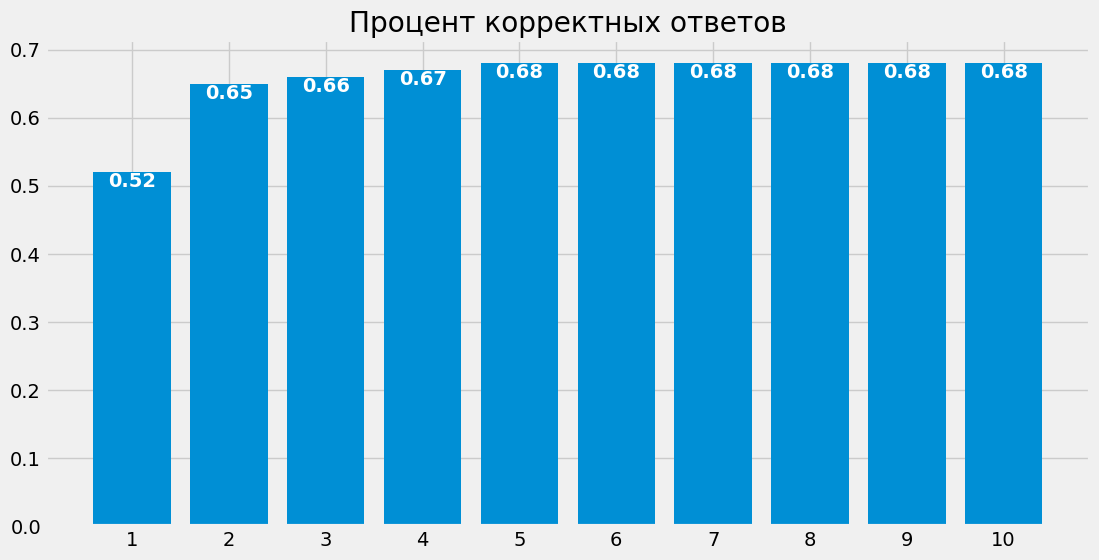

In [43]:
bins_correct_answers = answered_question_ts_df.iloc[:, 2].sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct_answers.index, bins_correct_answers.values)
for i, v in zip(bins_correct_answers.index, bins_correct_answers.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Процент корректных ответов")
plt.xticks(rotation=0)
plt.show()

Выводы:
- timestamp - это время между этим взаимодействием пользователя и завершением первого события от этого пользователя, т.е от старта регистрации на платформе обучения.
- Большинство взаимодействий происходит от пользователей, которые еще не были активны на платформе очень долго.
- Успеваимость студетов, которые только зарегистрировались ниже, чем студентов, учащихся на платформе уже некоторое время.
- Хорошей дополнительной переменной может стать "количество месяцев, прошедших с момента ррегистрации".

### Анализ переменной prior_question_had_explanation

Заполню пропуски в 'prior_question_had_explanation' = False, так как это соответствует тому что студент не видел ответ предыдущего вопроса или смотрел лекцию - прерывал сессию ответов на вопросы

In [51]:
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].fillna(value=False).astype(bool)

In [52]:
answered_question_mask = (train_df["answered_correctly"] != -1)

prior_question_df = (
    train_df.loc[answered_question_mask]
    .groupby(['prior_question_had_explanation'], dropna=False)
    .agg({'answered_correctly': ['mean', 'count']})
)
prior_question_df.head()

answered_correctly          
                                             mean     count
prior_question_had_explanation                             
False                                    0.507977   9585740
True                                     0.673189  89685560

In [53]:
prior_question = prior_question_df.iloc[:, 0]
prior_question

prior_question_had_explanation
False    0.507977
True     0.673189
Name: (answered_correctly, mean), dtype: float64

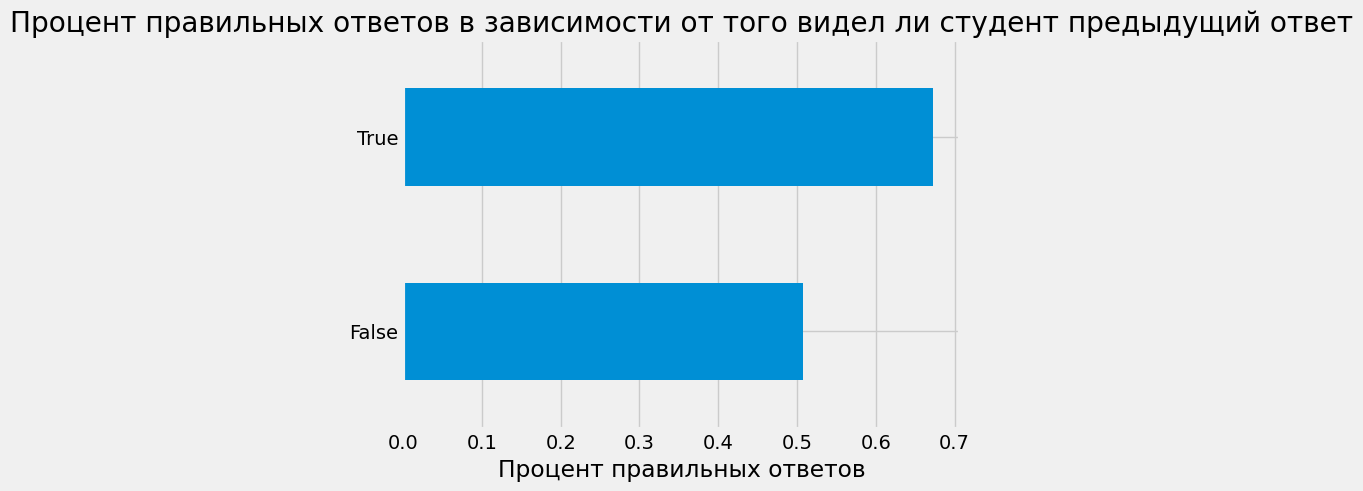

In [59]:
prior_question.plot.barh()
plt.title("Процент правильных ответов в зависимости от того видел ли студент предыдущий ответ")
plt.xlabel("Процент правильных ответов")
plt.ylabel(None)
plt.show()

Выводы:
- prior_question_had_explanation - Увидел ли пользователь объяснение и правильный ответ(ы) после ответа на предыдущий пакет вопросов, игнорируя любые лекции между ними.
- prior_question_had_explanation - соответствует непрерывной сессии ответов на вопросы
- Когда студент работает непрерывно - у него выше результаты

## EDA Questions

In [109]:
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [111]:
questions_df.shape

(13523, 5)

Проверка пропусков

In [121]:
questions_df[questions_df["correct_answer"].isna()]

,question_id,bundle_id,correct_answer,part,tags


In [122]:
questions_df[questions_df["part"].isna()]

,question_id,bundle_id,correct_answer,part,tags


In [123]:
questions_df[questions_df["tags"].isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


In [124]:
questions_df["tags"] = questions_df["tags"].fillna(0)

In [125]:
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [126]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13523 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [129]:
questions_df["part"].value_counts()

part
5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: count, dtype: int64

In [130]:
questions_df["correct_answer"].value_counts()

correct_answer
0    3716
3    3544
1    3478
2    2785
Name: count, dtype: int64

Построение списка тегов

In [131]:
questions_df['tags'] = questions_df['tags'].astype(str)

In [134]:
tags = [x.split() for x in questions_df[questions_df["tags"] != 0].tags.values]
tags = [item for tag_set in tags for item in tag_set]
tags = list(set(tags))

In [135]:
len(tags)

188

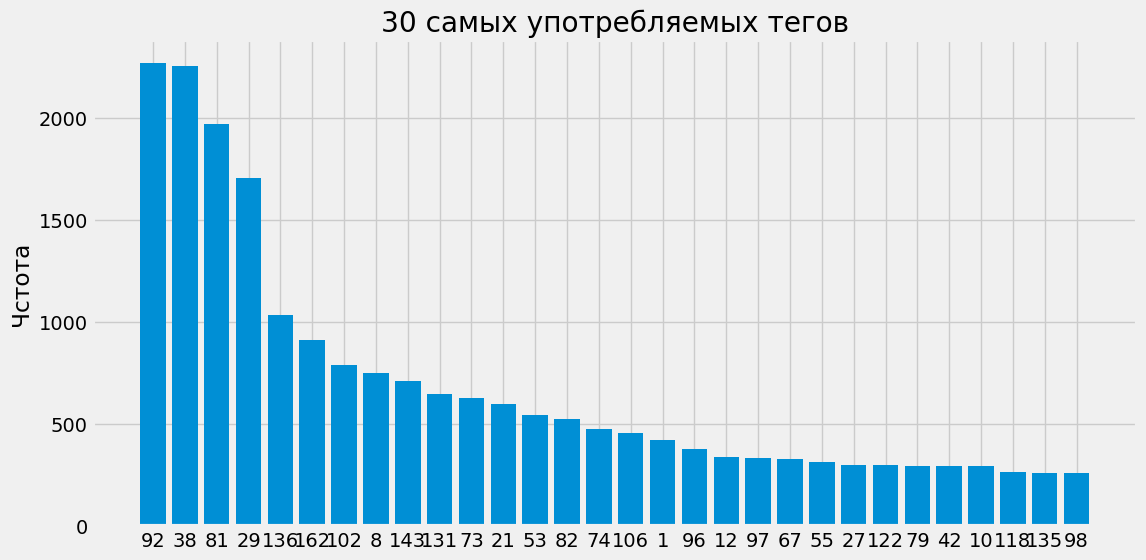

In [159]:
tags = [x.split() for x in questions_df[questions_df["tags"] != 0].tags.values]
tags = [item for tag_set in tags for item in tag_set]
tag_counter = Counter(tags)
most_common_tags = 30
y = [count for tag, count in tag_counter.most_common(most_common_tags)]
x = [tag for tag, count in tag_counter.most_common(most_common_tags)]

fig = plt.figure(figsize=(12,6))
plt.bar(x, y)
plt.title(f"{most_common_tags} самых употребляемых тегов")
plt.ylabel("Чстота")
plt.show()

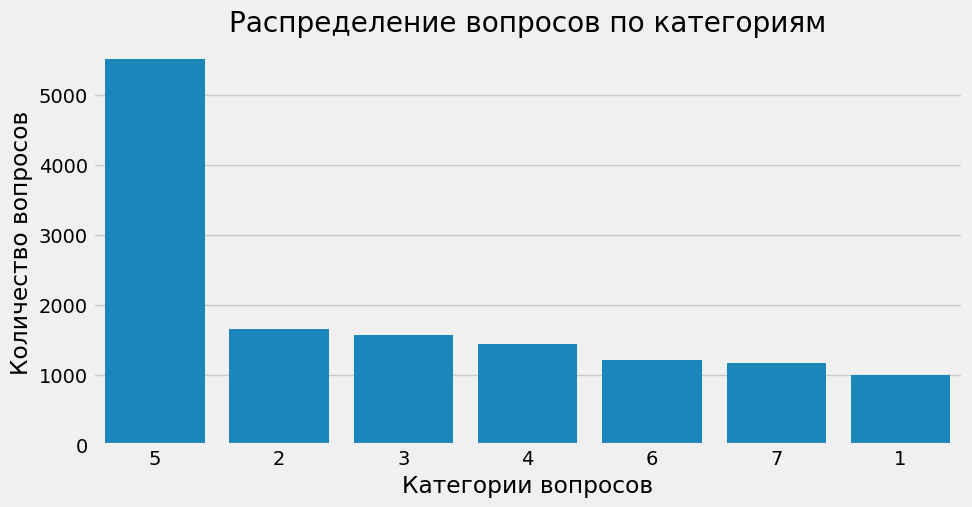

In [160]:
plt.figure(figsize=(10,5))
sns.countplot(x='part', data=questions_df, order=questions_df['part'].value_counts().index)
plt.title('Распределение вопросов по категориям')
plt.xlabel("Категории вопросов")
plt.ylabel("Количество вопросов")
plt.show()  

Можно построить зависимость правильности ответа от тега вопроса. Можно построить корректность ответов для каждой категории.

In [161]:
answered_question_mask = (train_df["answered_correctly"] != -1)

In [167]:
answered_correctly_df = (
    train_df.loc[answered_question_mask]
    .groupby(["content_id", 'answered_correctly'], as_index=False)
    .size()
)
answered_correctly_df = answered_correctly_df.pivot(index= "content_id", columns='answered_correctly', values='size')
answered_correctly_df.columns = ['wrong', 'right']
answered_correctly_df = answered_correctly_df.fillna(0)

In [168]:
answered_correctly_df.head()

,wrong,right
content_id,,
0,637.0,6266.0
1,809.0,6589.0
2,20015.0,24890.0
3,5067.0,17906.0
4,12275.0,19461.0


In [169]:
questions_answers_df = questions_df.merge(answered_correctly_df, left_on="question_id", right_on="content_id", how="left")

In [170]:
tags_list = [x.split() for x in questions_answers_df.tags.values]
questions_answers_df['tags'] = tags_list

In [171]:
questions_answers_df.head()

,question_id,bundle_id,correct_answer,part,tags,wrong,right
0,0,0,0,1,"[51, 131, 162, 38]",637.0,6266.0
1,1,1,1,1,"[131, 36, 81]",809.0,6589.0
2,2,2,0,1,"[131, 101, 162, 92]",20015.0,24890.0
3,3,3,0,1,"[131, 149, 162, 29]",5067.0,17906.0
4,4,4,3,1,"[131, 5, 162, 38]",12275.0,19461.0


In [177]:
questions_answers_df.shape

(13523, 7)

Теперь я могу сложить все Неправильные и Правильные ответы для всех вопросов, помеченных определенным тегом, и вычислить процент правильных ответов для каждого тега. 
Обратите внимание, что существует «двойной подсчет» вопросов; например, если у вопроса 5 тегов, его ответы суммируются в суммах каждого из 5 тегов.

In [ ]:
Выводы:
- 

## EDA Lectures

In [113]:
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [68]:
lectures_df.shape

(418, 4)

Проверка пропусков

In [115]:
sum(lectures_df.tag.isna())

0

In [116]:
sum(lectures_df.part.isna())

0

In [117]:
sum(lectures_df.type_of.isna())

0

In [137]:
lectures_df["tag"].value_counts().shape

(151,)

In [69]:
lectures_df["type_of"].value_counts()

type_of
concept             222
solving question    186
intention             7
starter               3
Name: count, dtype: int64

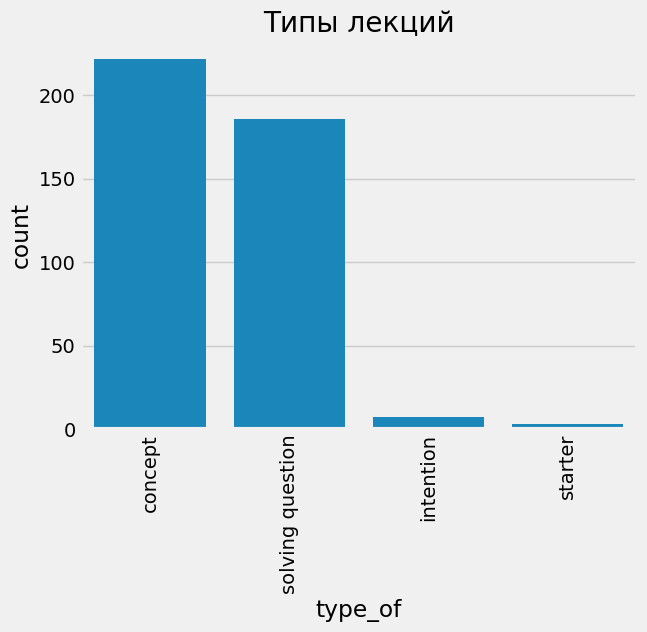

In [77]:
sns.countplot(x='type_of', data=lectures_df, order=lectures_df['type_of'].value_counts().index)
plt.title('Типы лекций')
plt.xticks(rotation=90)
plt.show()  

In [80]:
lectures_df["part"].value_counts()

part
5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: count, dtype: int64

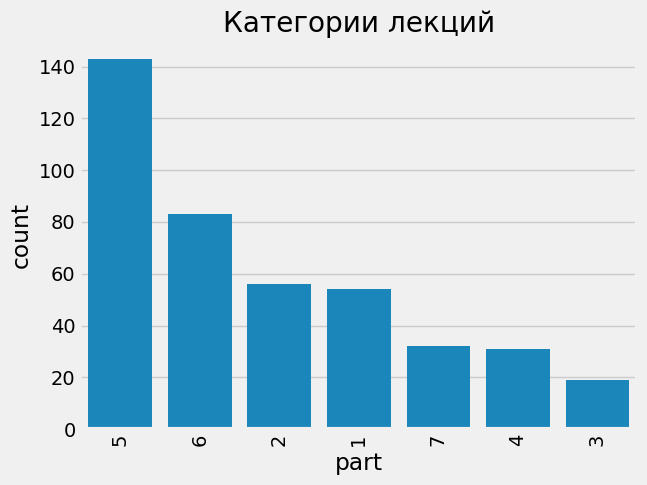

In [81]:
sns.countplot(x='part', data=lectures_df, order=lectures_df['part'].value_counts().index)
plt.title('Категории лекций')
plt.xticks(rotation=90)
plt.show()  

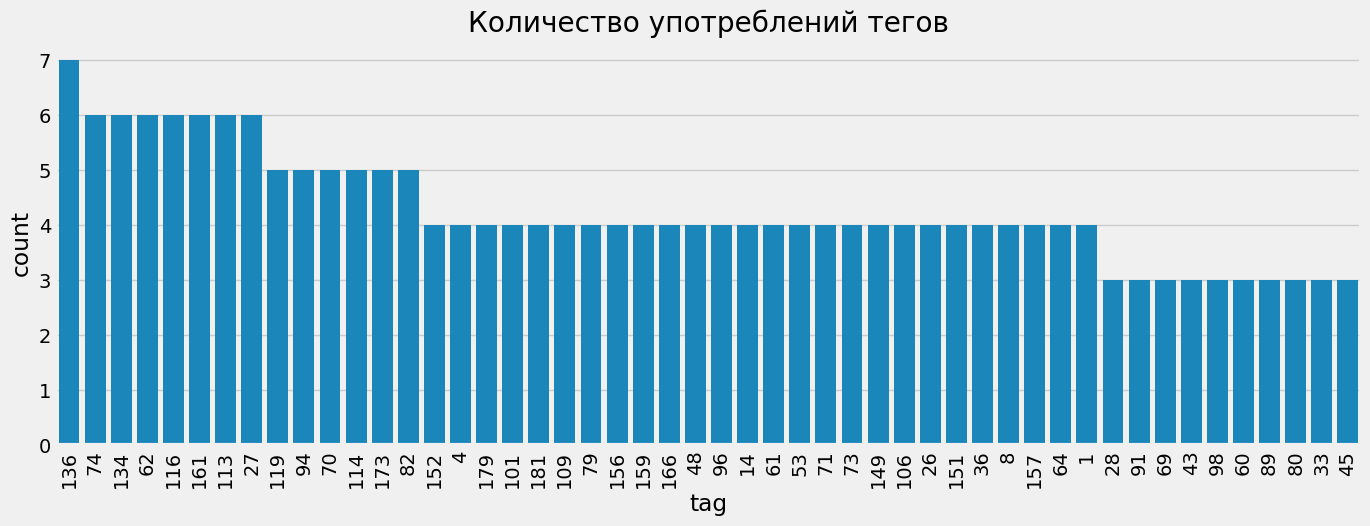

In [73]:
plt.figure(figsize=(15, 5))
sns.countplot(x='tag', data=lectures_df, order=lectures_df['tag'].value_counts().iloc[:50].index)
plt.title('Количество употреблений тегов')
plt.xticks(rotation=90)
plt.show()

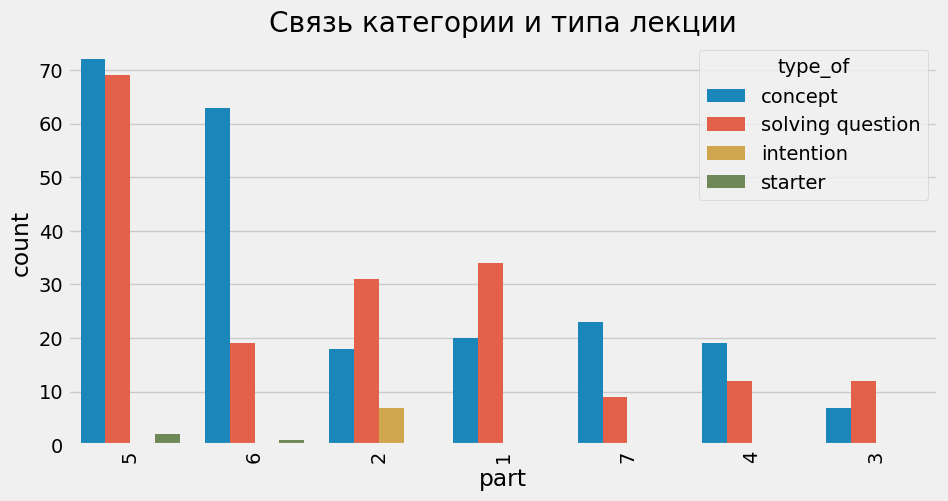

In [82]:
plt.figure(figsize=(10,5))
sns.countplot(x='part', data=lectures_df, hue='type_of', order=lectures_df['part'].value_counts().index)
plt.title('Связь категории и типа лекции')
plt.xticks(rotation=90)
plt.show()  

Посмотрю на связь оценки и просмотра лекций

In [90]:
user_lecture_df = (
    train_df.groupby(["user_id", "answered_correctly"])
    .size()
    .unstack()
)
user_lecture_df.head()

answered_correctly,-1,0,1
user_id,,,
115,NaN,14.0,32.0
124,NaN,23.0,7.0
2746,1.0,8.0,11.0
5382,3.0,41.0,84.0
8623,3.0,39.0,70.0


In [91]:
user_lecture_df.columns = ['lecture', 'wrong', 'right']

In [95]:
user_lecture_df['lecture'] = user_lecture_df['lecture'].fillna(0)

In [96]:
user_lecture_df.head()

,lecture,wrong,right
user_id,,,
115,0.0,14.0,32.0
124,0.0,23.0,7.0
2746,1.0,8.0,11.0
5382,3.0,41.0,84.0
8623,3.0,39.0,70.0


In [97]:
user_lecture_df['watch_lecture'] = user_lecture_df['lecture'].apply(lambda x: x > 0)

In [98]:
user_lecture_df.head()

,lecture,wrong,right,watch_lecture
user_id,,,,
115,0.0,14.0,32.0,False
124,0.0,23.0,7.0,False
2746,1.0,8.0,11.0,True
5382,3.0,41.0,84.0,True
8623,3.0,39.0,70.0,True


In [100]:
watch_lecture_df = (
    user_lecture_df.groupby("watch_lecture")
    .agg({
        'wrong': ['sum'], 
        'right': ['sum']
    })
)
watch_lecture_df.head()

,wrong,right
,sum,sum
watch_lecture,,
False,5330919.0,7185795.0
True,28695754.0,58058832.0


In [101]:
watch_lecture_df['correct'] = watch_lecture_df["right"] / (watch_lecture_df["right"] + watch_lecture_df["wrong"])

In [102]:
watch_lecture_df.head()

,wrong,right,correct
,sum,sum,
watch_lecture,,,
False,5330919.0,7185795.0,0.574096
True,28695754.0,58058832.0,0.669231


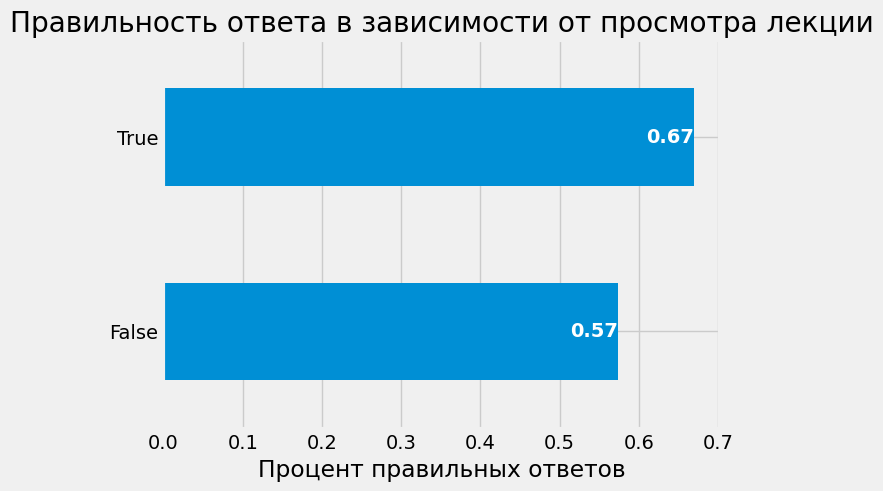

In [108]:
watch_lecture = watch_lecture_df.iloc[:, 2]
watch_lecture.plot.barh()
for i, v in zip(watch_lecture.index, watch_lecture.values):
    plt.text(v, i, round(v, 2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("Правильность ответа в зависимости от просмотра лекции")
plt.xlabel("Процент правильных ответов")
plt.ylabel(None)
plt.xticks(rotation=0)
plt.show()

Выводы:
- Всего тегов для лекций - 151
- Больше всего лекций по концепциям и решениям задач
- В каждой категории больше всего лекций, связанных с концепциям и решениям задач
- Успеваимость выше у тех студентов, которые смотрели лекции

# END